# La méthode de K-SVD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# bibliotheques de machine learning
from sklearn import linear_model
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

# bibliotheques d'images
import scipy.misc
import skimage.io as io
import skimage.color as color

### L'algorithme de K-SVD

In [2]:
def ksvd(y, K, m0, epsilon, iter_max):
    #on initialise le dictionnaire D
    U, S, V = np.linalg.svd(y)
    D = U[:, :K]
    
    i=0
    erreur=3*epsilon
    while erreur >= epsilon and i<iter_max:
        # on met a jour la representation creuse
        x_creux = linear_model.orthogonal_mp(D, y, n_nonzero_coefs=m0)
    
        # on met a jour le dictionnaire selon l'algorithme de K-SVD
        for k in range(K):
            index = np.nonzero(x_creux[k, :])[0]
            
            if len(index) != 0:
                D[:, k] = np.zeros(np.shape(D)[0])
                E = (y - np.dot(D, x_creux))[:, index]
                U, S, V = np.linalg.svd(E, full_matrices=False)
                D[:, k] = U[:, 0]
                x_creux[k, index] = S[0] * V[0, :]
            
        erreur = np.linalg.norm(y - np.dot(D, x_creux))   # norme de Frobenius
        i+=1
            

    x_creux = linear_model.orthogonal_mp(D, y, n_nonzero_coefs=m0)
    return D, x_creux

### Exemple 1 : sur une image d'ascension d'un escalier

In [3]:
image_init = scipy.misc.ascent().astype(np.float)
print(np.shape(image_init))

K=200
iter_max=30
epsilon=1e-6
m0=int(np.shape(image_init)[1]/10.)

D_ksvd, x_creux_ksvd = ksvd(image_init, K, m0, epsilon, iter_max)
plt.figure(1)
plt.clf()
plt.subplot(1, 2, 1)
plt.gray()
plt.imshow(image_init)
plt.suptitle('image initiale (512 x 512)')

plt.subplot(1, 2, 2)
plt.gray()
plt.imshow(np.dot(D_ksvd,x_creux_ksvd))
plt.suptitle('reconstruction par K-SVD (K=200)')

plt.show()

/var/folders/_n/5x8lffcd2sv4kf05ty9bm4200000gp/T/ipykernel_7014/1922992377.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_init = scipy.misc.ascent().astype(np.float)


(512, 512)


### Exemple 2 : sur l'image de Léna (comparaison avec l'apprentissage de dictionnaire en ligne)
##### résultat avec la K-SVD

In [3]:
image_init = io.imread("lena.tiff")
image_init = color.rgb2gray(image_init) 
print(np.shape(image_init))

K=100
iter_max=30
epsilon=1e-6
m0=int(np.shape(image_init)[1]/10.)

D_ksvd, x_creux_ksvd = ksvd(image_init, K, m0, epsilon, iter_max)
plt.figure(2)
plt.clf()
plt.subplot(1, 2, 1)
plt.gray()
plt.imshow(image_init)
plt.suptitle('image initiale (512 x 512)')

plt.subplot(1, 2, 2)
plt.gray()
plt.imshow(np.dot(D_ksvd,x_creux_ksvd))
plt.suptitle('reconstruction par K-SVD (K=100)')

plt.show()

(512, 512)


#### résultat avec l'apprentissage en ligne

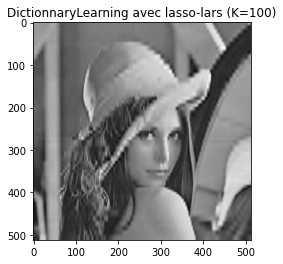

In [4]:
# Attention avec la bibliotheque de Scikit-Learn les matrices sont transposees (on a donc X*D et non D*X)
# avec Lasso Lars pour l'étape sur X
image_init = io.imread("lena.tiff")
image_init = color.rgb2gray(image_init) 
m0=int(np.shape(image_init)[1]/10.)

dict_learner = DictionaryLearning(n_components=100, transform_algorithm='lasso_lars', transform_n_nonzero_coefs=m0, random_state=42,)
x_creux_lasso_lars = dict_learner.fit_transform(image_init)
D_lasso_lars=dict_learner.components_
 
plt.figure(3)
plt.clf()
plt.gray()
plt.imshow(np.dot(x_creux_lasso_lars, D_lasso_lars))
plt.title('DictionnaryLearning avec lasso-lars (K=100)')
plt.show()

# avec omp pour l'étape sur X
image_init = io.imread("lena.tiff")
image_init = color.rgb2gray(image_init) 

dict_learner = DictionaryLearning(n_components=100, transform_algorithm='omp', transform_n_nonzero_coefs=m0, random_state=42,)
x_creux_omp = dict_learner.fit_transform(image_init)
D_omp=dict_learner.components_

plt.figure(4)
plt.clf()
plt.gray()
plt.imshow(np.dot(x_creux_omp, D_omp))
plt.title('DictionnaryLearning avec omp (K=100)')
plt.show()


### Exemple 3 : comparaison d'apprentissage de Dictionnaire (K-SVD vs Gradient stochastique projeté)

256 256


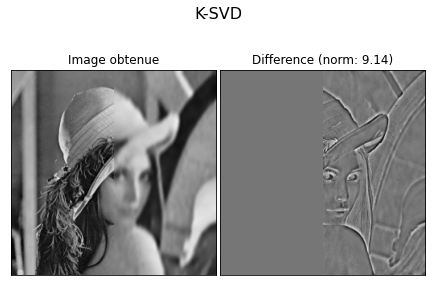

In [7]:
# -------------- image initale (a droite correcte, a gauche bruitee)----------
lena = io.imread("lena.tiff")
lena = color.rgb2gray(lena) 

plt.figure(1)
plt.clf()
plt.gray()
plt.imshow(lena)
plt.show()

# sous echantillonnage pour aller plus vite
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]
lena /= 4.0
height, width = lena.shape
print(height, width)


# on bruite la partie droite de l'image
image_bruitee = lena.copy()
image_bruitee[:, height // 2:] += 0.075 * np.random.randn(width, height // 2)
plt.figure(2)
plt.clf()
plt.gray()
plt.imshow(image_bruitee)
plt.show()


# ---------- difference entre image de reference et image bruitee -------------

def show_with_diff(image_bruitee, image_reference, title):
    plt.subplot(1, 2, 1)
    plt.title('Image obtenue')
    plt.gray()
    plt.imshow(image_bruitee)
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image_bruitee - image_reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.gray()
    plt.imshow(difference)
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

plt.figure(3)
plt.clf()
show_with_diff(image_bruitee, lena, 'Image bruitee')

# ----- preparation des données (=patches corrects, a gauche de l'image) ------
patch_size = (7, 7)
data_gauche = extract_patches_2d(image_bruitee[:, :height // 2], patch_size)
data_gauche = data_gauche.reshape(data_gauche.shape[0], -1)
data_gauche -= np.mean(data_gauche, axis=0)
data_gauche /= np.std(data_gauche, axis=0)

# ------------ apprentissage du dictionnaire sur les patches corrects----------
# methode Dictionnary Learning
dico = MiniBatchDictionaryLearning(5, alpha=1, n_iter=500)
D_DicLearn = dico.fit(data_gauche).components_

#methode K-SVD
def ksvd(y, K, epsilon, iter_max):
    #on initialise le dictionnaire D
    U, S, V = np.linalg.svd(y)
    D = U[:, :K]
    
    i=0
    erreur=3*epsilon
    while erreur >= epsilon and i<iter_max:
        
        # on met a jour la representation creuse
        x_creux = linear_model.orthogonal_mp(D, y)
    
        # on met a jour le dictionnaire selon l'algorithme de KSVD
        for k in range(K):
            index = np.nonzero(x_creux[k, :])[0]
            
            if len(index) != 0:
                D[:, k] = np.zeros(np.shape(D)[0])
                E = (y - np.dot(D, x_creux))[:, index]
                U, S, V = np.linalg.svd(E, full_matrices=False)
                D[:, k] = U[:, 0]
                x_creux[k, index] = S[0] * V[0, :]
            
        erreur = np.linalg.norm(y - np.dot(D, x_creux))   # norme de Frobenius
        i+=1
            

    x_creux = linear_model.orthogonal_mp(D, y)
    return D, x_creux

D_ksvd, x_creux_gauche_ksvd=ksvd(np.transpose(data_gauche), 5, 1.e-6, 500)

# ---données bruitees (patches a droite) et reconstruction avec le dictionnaire---
data_droite = extract_patches_2d(image_bruitee[:, height // 2:], patch_size)
data_droite = data_droite.reshape(data_droite.shape[0], -1)
moyenne=np.mean(data_droite, axis=0)
data_droite -= moyenne


# reconstruction avec l'apprentissage en ligne
reconstruction = lena.copy()
dico.set_params(transform_algorithm='lars', transform_n_nonzero_coefs=5)
x_creux_lars = dico.transform(data_droite)

patches = np.dot(x_creux_lars, D_DicLearn)
patches += moyenne
patches = patches.reshape(len(data_droite), *patch_size)
reconstruction[:, height // 2:] = reconstruct_from_patches_2d(patches, (width, height // 2))
plt.figure(4)
show_with_diff(reconstruction, lena, 'Lars 5 atoms')
plt.show()

# reconstruction avec K-SVD
x_creux_droit = linear_model.orthogonal_mp(D_ksvd, np.transpose(data_droite))
patches = np.dot(D_ksvd, x_creux_droit)
patches=np.transpose(patches)
patches += moyenne
patches = patches.reshape(len(data_droite), *patch_size)
image_finale = lena.copy()
image_finale[:, height // 2:] = reconstruct_from_patches_2d(patches, (width, height // 2))
plt.figure(5)
show_with_diff(image_finale, lena, 'K-SVD')
plt.show()
